In [1]:
# Loading necessary libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

2026-02-16 12:56:56.353945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771246616.539228      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771246616.591694      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771246617.020788      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771246617.020837      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771246617.020840      55 computation_placer.cc:177] computation placer alr

In [7]:
# Creating path for UTKFace dataset
path = Path("../input/utkface-new/UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [9]:
import os

for root, dirs, files in os.walk("/kaggle/input"):
    for file in files[:10]:
        print(root, file)
        break


/kaggle/input/datasets/jangedoo/utkface-new/UTKFace 26_0_2_20170104023102422.jpg.chip.jpg
/kaggle/input/datasets/jangedoo/utkface-new/utkface_aligned_cropped/UTKFace 26_0_2_20170104023102422.jpg.chip.jpg
/kaggle/input/datasets/jangedoo/utkface-new/utkface_aligned_cropped/crop_part1 26_0_2_20170104023102422.jpg.chip.jpg
/kaggle/input/datasets/jangedoo/utkface-new/crop_part1 26_0_2_20170104023102422.jpg.chip.jpg


In [14]:
from pathlib import Path

DATASET_PATH = Path("/kaggle/input/datasets/jangedoo/utkface-new/UTKFace")

image_paths = list(DATASET_PATH.glob("*.jpg"))

print("Total UTKFace images:", len(image_paths))
print(image_paths[:5])


Total UTKFace images: 23708
[PosixPath('/kaggle/input/datasets/jangedoo/utkface-new/UTKFace/26_0_2_20170104023102422.jpg.chip.jpg'), PosixPath('/kaggle/input/datasets/jangedoo/utkface-new/UTKFace/22_1_1_20170112233644761.jpg.chip.jpg'), PosixPath('/kaggle/input/datasets/jangedoo/utkface-new/UTKFace/21_1_3_20170105003215901.jpg.chip.jpg'), PosixPath('/kaggle/input/datasets/jangedoo/utkface-new/UTKFace/28_0_0_20170117180555824.jpg.chip.jpg'), PosixPath('/kaggle/input/datasets/jangedoo/utkface-new/UTKFace/17_1_4_20170103222931966.jpg.chip.jpg')]


In [16]:
from pathlib import Path

path = Path("/kaggle/input/datasets/jangedoo/utkface-new/UTKFace")

filenames = list(map(lambda x: x.name, path.glob("*.jpg")))

print(len(filenames))
print(filenames[:5])

23708
['26_0_2_20170104023102422.jpg.chip.jpg', '22_1_1_20170112233644761.jpg.chip.jpg', '21_1_3_20170105003215901.jpg.chip.jpg', '28_0_0_20170117180555824.jpg.chip.jpg', '17_1_4_20170103222931966.jpg.chip.jpg']


In [17]:
# Shuffling the data
np.random.seed(42)
np.random.shuffle(filenames)

In [18]:
# Separating age and gender
age_labels, gender_labels, image_path = [], [], []
for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [19]:
# Creating new dataframe 'data' with just 'image', 'age', and 'gender' columns
data = pd.DataFrame()
data['image'], data['age'], data['gender'] = image_path, age_labels, gender_labels

In [20]:
# Mapping gender=0 to "Male" and gender=1 to "Female"
gender_dict = {0:"Male",1:"Female"}

In [21]:
print(data.dtypes)

image     object
age       object
gender    object
dtype: object


In [22]:
data = data.astype({'age':'float32', 'gender': 'int32'})

In [23]:
data.head()

,image,age,gender
0,85_0_0_20170111210408610.jpg.chip.jpg,85.0,0
1,24_1_3_20170104222753607.jpg.chip.jpg,24.0,1
2,8_0_4_20170103200427437.jpg.chip.jpg,8.0,0
3,56_1_0_20170110123126617.jpg.chip.jpg,56.0,1
4,28_1_1_20170117121837397.jpg.chip.jpg,28.0,1


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   23708 non-null  object 
 1   age     23708 non-null  float32
 2   gender  23708 non-null  int32  
dtypes: float32(1), int32(1), object(1)
memory usage: 370.6+ KB


[Text(0.5, 1.0, 'Distribution of Age')]

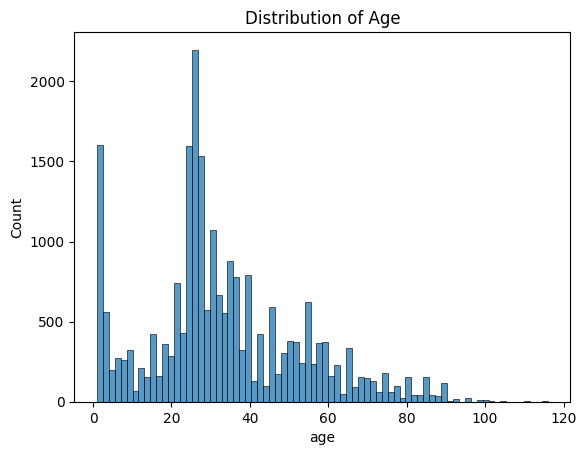

In [25]:
sns.histplot(data.age).set(title="Distribution of Age")

[Text(0.5, 1.0, 'Distribution of Gender')]

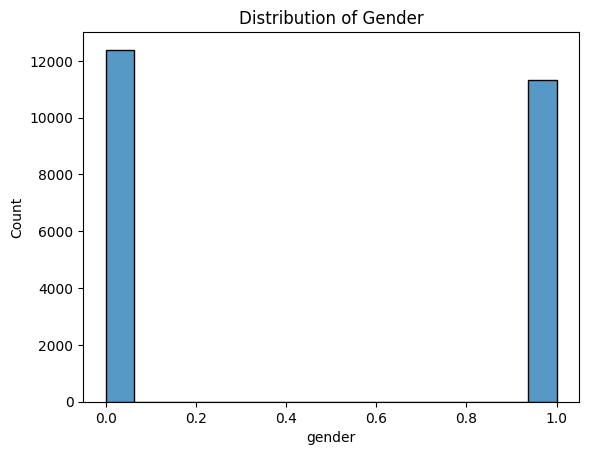

In [26]:
sns.histplot(data.gender).set(title="Distribution of Gender")

In [27]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [29]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

x_train = []

for file in train.image:
    img = load_img(
        "/kaggle/input/datasets/jangedoo/utkface-new/UTKFace/" + file,
        color_mode="grayscale",      
        target_size=(128,128)        
    )
    
    img = img_to_array(img)
    x_train.append(img)

x_train = np.array(x_train)

print(x_train.shape)

(18966, 128, 128, 1)


In [30]:
x_train = x_train/255
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [31]:
input_size = (128,128,1)

In [32]:
# Building the CNN model
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

I0000 00:00:1771247415.135973      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [36]:
model.compile(
    optimizer='adam',

    loss = {
        'gender_output': 'binary_crossentropy',
        'age_output': 'mse'
    },

    metrics = {
        'gender_output': ['accuracy'],
        'age_output': ['mae']
    }
)

In [37]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 126, 126,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 42, 42,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 40, 40,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 20, 20,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 18, 18,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 9, 9, 256) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 20736)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  5,308,672 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  5,308,672 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        257 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,020,546 (42.04 MB)

 Trainable params: 11,020,418 (42.04 MB)

 Non-trainable params: 128 (512.00 B)

In [38]:
history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=20, validation_split= 0.1)

Epoch 1/20


I0000 00:00:1771247563.119672     188 service.cc:152] XLA service 0x7fd1180049a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771247563.119722     188 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771247563.743206     188 cuda_dnn.cc:529] Loaded cuDNN version 91002


  20/1707 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - age_output_loss: 967.0048 - age_output_mae: 25.5888 - gender_output_accuracy: 0.5234 - gender_output_loss: 2.5892 - loss: 969.5941 

I0000 00:00:1771247567.365902     188 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1707/1707 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - age_output_loss: 356.5535 - age_output_mae: 14.1729 - gender_output_accuracy: 0.6905 - gender_output_loss: 0.6579 - loss: 357.2114 - val_age_output_loss: 637.2363 - val_age_output_mae: 22.4409 - val_gender_output_accuracy: 0.7707 - val_gender_output_loss: 0.4407 - val_loss: 637.0431
Epoch 2/20
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - age_output_loss: 151.8347 - age_output_mae: 9.1458 - gender_output_accuracy: 0.8205 - gender_output_loss: 0.3855 - loss: 152.2202 - val_age_output_loss: 142.1463 - val_age_output_mae: 8.8049 - val_gender_output_accuracy: 0.8160 - val_gender_output_loss: 0.3497 - val_loss: 142.4478
Epoch 3/20
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - age_output_loss: 129.7652 - age_output_mae: 8.3264 - gender_output_accuracy: 0.8367 - gender_output_loss: 0.3557 - loss: 130.1209 - val_age_output_loss: 176.6385 - val_age_output_mae: 9.7467 - val_gender_output_accuracy: 0.8593 - val_gender_output_loss: 0.3123 - val_loss: 

In [69]:
train_gender_acc = history.history['gender_output_accuracy'][-1]
train_age_mae = history.history['age_output_mae'][-1]

print("\nTraining Gender Accuracy : {:.2f}%".format(train_gender_acc*100))
print("Training Age MAE : {:.2f} years".format(train_age_mae))



Training Gender Accuracy : 89.58%
Training Age MAE : 5.08 years


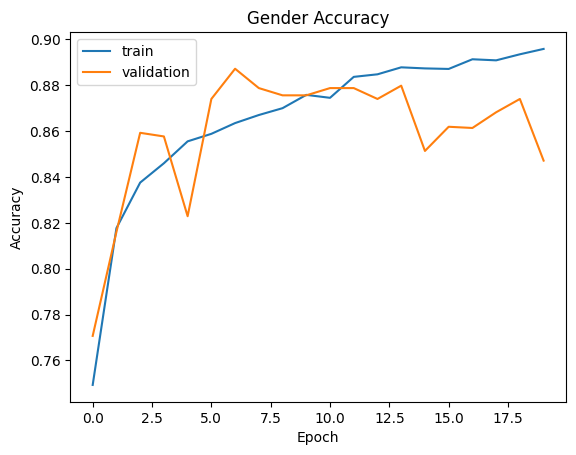

In [39]:
# Plotting gender accuracy 
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('Gender Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

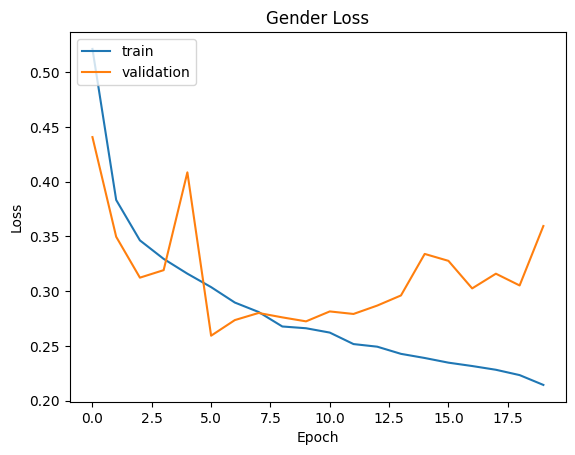

In [40]:
# Plotting gender loss 
plt.plot(history.history['gender_output_loss'])
plt.plot(history.history['val_gender_output_loss'])
plt.title('Gender Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

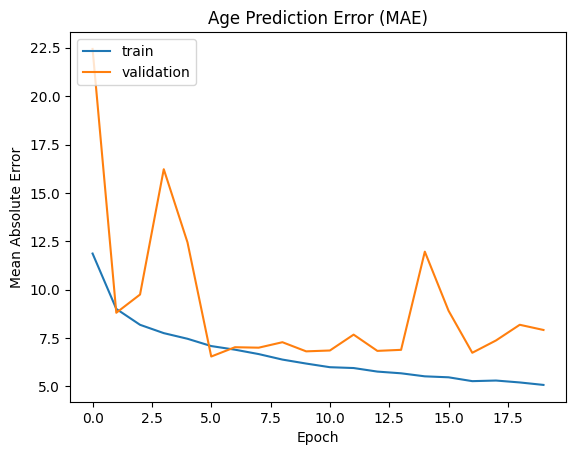

In [42]:
plt.plot(history.history['age_output_mae'])
plt.plot(history.history['val_age_output_mae'])

plt.title('Age Prediction Error (MAE)')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()


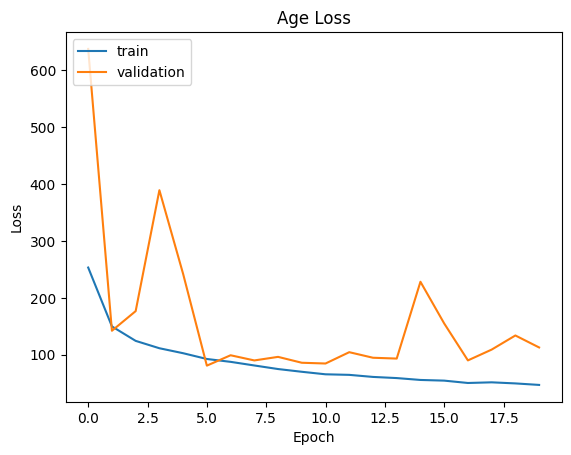

In [43]:
# Plotting age loss 
plt.plot(history.history['age_output_loss'])
plt.plot(history.history['val_age_output_loss'])
plt.title('Age Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Original: Gender =  Female  Age =  25.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction: Gender =  Female  Age =  28


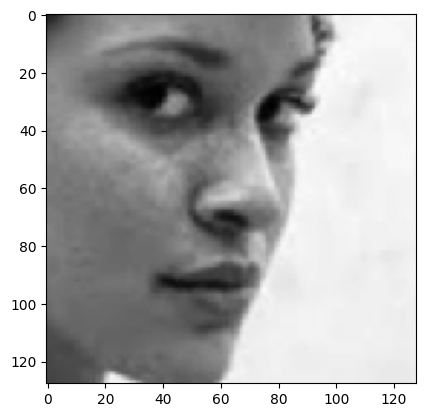

In [72]:
# Applying model predictions to a test image
index=45
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

In [58]:
model.save("age_gender_model.h5")
print("Model saved successfully")


Model saved successfully


In [64]:
import ipywidgets as widgets
from IPython.display import display

uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)


FileUpload(value=(), accept='image/*', description='Upload')

In [65]:
if len(uploader.value) == 0:
    print("No file uploaded")
else:
    print("File uploaded successfully")

File uploaded successfully


(np.float64(-0.5), np.float64(523.5), np.float64(678.5), np.float64(-0.5))

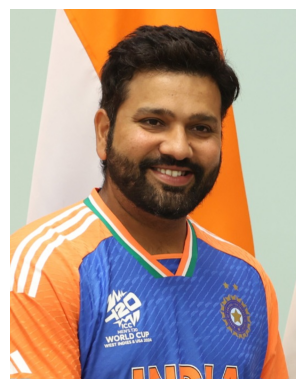

In [66]:
uploaded_file = uploader.value[0]
file_name = uploaded_file['name']
file_content = uploaded_file['content']

with open(file_name, "wb") as f:
    f.write(file_content)

from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(file_name)
plt.imshow(img)
plt.axis('off')


In [67]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

img = load_img(file_name, color_mode="grayscale", target_size=(128,128))
img = img_to_array(img)/255.0
img = img.reshape(1,128,128,1)

pred = model.predict(img)

print("Gender:", gender_dict[round(pred[0][0][0])])
print("Age:", round(pred[1][0][0]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Gender: Male
Age: 41
